In [1]:
import idx2numpy
import seaborn as sns
X_train_3D = idx2numpy.convert_from_file('../MNIST_dataset/train-images-idx3-ubyte')
X_train = X_train_3D.flatten().reshape(60000,784)

y_train = idx2numpy.convert_from_file('../MNIST_dataset/train-labels-idx1-ubyte')
print(X_train.shape, y_train.shape)
X_test_3D = idx2numpy.convert_from_file('../MNIST_dataset/t10k-images-idx3-ubyte')
X_test =  X_test_3D.flatten().reshape(10000,784)

y_test = idx2numpy.convert_from_file('../MNIST_dataset/t10k-labels-idx1-ubyte')
print(X_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [2]:
import numpy as np
from sklearn.utils import shuffle
X_shuffle,y_shuffle = shuffle(X_train,y_train)
X_train = X_shuffle[0:50000]
y_train = y_shuffle[0:50000]

from sklearn import tree
from sklearn.model_selection import cross_val_predict
dt_max_depth=11
#dt_clf = tree.DecisionTreeClassifier(max_depth=20, max_leaf_nodes=300)
dt_clf = tree.DecisionTreeClassifier(max_depth=dt_max_depth)

y_train_pred = cross_val_predict(dt_clf, X_train, y_train, cv=2)
print(dt_clf.fit(X_train, y_train))

print('Number of nodes in the decision tree {}.'.format(dt_clf.tree_.node_count))
print('Number of threshold in the decision tree {}.'.format(len(dt_clf.tree_.threshold)))
print('Number of leaves in the decision tree {}. It will be number of states in sequential FSM.'.format(dt_clf.tree_.n_leaves))

from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, dt_clf.predict(X_train)), accuracy_score(y_test, dt_clf.predict(X_test)))

DecisionTreeClassifier(max_depth=11)
Number of nodes in the decision tree 2637.
Number of threshold in the decision tree 2637.
Number of leaves in the decision tree 1319. It will be number of states in sequential FSM.
0.93304 0.8689


#### Run this cell twice.

In [4]:
%%capture cap --no-stderr
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}{}:if ({} <= {})".format(indent, node, name, int(round(threshold,3)))) 
            recurse(tree_.children_left[node], depth + 1)
            print ("{}{}:else ".format(indent, node, name, int(round(threshold,3))))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{} Label<={};".format(indent, np.argmax(tree_.value[node][0],axis=0)))

    recurse(0, 1)

cols = range(784)
features = ['pixels[{}]'.format(str(i)) for i in cols]
class_names = [str(i) for i in dt_clf.classes_]
tree_to_code(dt_clf, features)

with open('decision_rules_mnist.txt', 'w') as f:
    f.write(cap.stdout)

#### Run this cell twice.

In [6]:
%%capture cap --no-stderr

import pdb
def write_file(data_towrite):
    with open('verilog_file.v', 'a', encoding='utf-8') as file:
        file.writelines(data_towrite)
        file.close()
        
def write_line_file(data_towrite, line_num):
    with open('verilog_file.v', 'r', encoding='utf-8') as file:
        file_content = file.readlines()
        file.close()
    file_content[line_num] = file_content[line_num].replace('\n','') + ' ' + data_towrite + '\n'  
    with open('verilog_file.v', 'w', encoding='utf-8') as file:
        file.writelines(file_content)
        file.close()
        
def search_content_file(word):
    with open('verilog_file.v', 'r') as file:
        file_content = file.readlines()
        for line_num,line in enumerate(file_content):
            if word in line:
                return(line_num)
        return("content doesn't exists.")
    
def update_stateformat_file():
    with open('verilog_file.v', 'r', encoding='utf-8') as file:
        file_content = file.readlines()
        file.close()
    for line_num,line in enumerate(file_content):
        if 'if' in line:
            file_content[line_num] = '    case ' + file_content[line_num].strip() + ' \n'  
    with open('verilog_file.v', 'w', encoding='utf-8') as file:
        file.writelines(file_content)
        file.close()
        
def clear_file():
    with open('verilog_file.v', 'w', encoding='utf-8') as file:
        pass
        file.close()
        
def print_file_content():
    with open('verilog_file.v', 'r', encoding='utf-8') as file:
        file_content = file.read()
        file.close()
    print(file_content)


import itertools
with open('decision_rules_mnist.txt', 'r') as f:
    tree_verilog = f.read()
    f.close()

clear_file()
line_num = 0
else_state = 0
else_nextif_state = 0
curr_line,next_line = itertools.tee(tree_verilog.split('\n'))
next(next_line, None)
for i,j in list(zip(curr_line,next_line)):
    if 'Label' in i:
        pass
        #write_file(f'  begin {i.strip()} state<=0;ml_inference_completed<=1; end \n')
    elif 'else' in i and 'Label' in j:
        else_state = i.strip().split(':')[0]
        line_num = search_content_file(' '+str(else_state)+':if' )
        spaces = 12-len(str(line_num))
        spaces = ' '*spaces
        write_line_file(f'\n{spaces}else:  {j.strip().replace("<","")} state=0;ml_inference_completed=1; clock_counter = clock_counter+1;', line_num)
    elif 'else' in i and 'if' in j:
        else_state = i.strip().split(':')[0]
        else_nextif_state = j.strip().split(':')[0]
        line_num = search_content_file(' '+str(else_state)+':if' )
        spaces = 12-len(str(line_num))
        spaces = ' '*spaces
        write_line_file(f' \n{spaces}else: state={else_nextif_state}; clock_counter = clock_counter+1;', line_num)
    elif 'if' in i and 'Label' in j:
        write_file(f' {i.strip()}:  {j.strip().replace("<","")} state=0;ml_inference_completed<=1; clock_counter = clock_counter+1; ')
    elif 'if' in i and 'if' in j:
        write_file(f' {i.strip()}: clock_counter = clock_counter+1; state={j.strip().split(":")[0]};  \n ')  
update_stateformat_file()
print('def inference_rate(pixels):')
print(' clock_counter=0; state=0; Label=10; ml_inference_completed=0; #assigning dummy default label to 10')
print(' while(Label == 10):')
print('  match state:')
print_file_content()
print(' return (Label,clock_counter)')

with open('mnist_dt_case_fsm.py', 'w') as f:
    f.write(cap.stdout)

In [7]:
# Aligning the spaces
with open('mnist_dt_case_fsm.py', 'r') as f:
    py_fsm = f.readlines()
    f.close()
    
curr_line,next_line = itertools.tee(py_fsm)
next(next_line, None)
for i,j in list(zip(curr_line,next_line)):
    if 'if' in i and 'else' in j:
        if len(i.split('if')[0]) != len(j.split('else')[0]):
            py_fsm[py_fsm.index(j)] = ' '* (len(i.split('if')[0]) - len(j.split('else')[0])) + py_fsm[py_fsm.index(j)]
            

for i in py_fsm:
    if 'case' in i:
        py_fsm[py_fsm.index(i)] = i.split(':if')[0]+':\n'+ ' '*(len(i.split(':if')[0])+1) + 'if' + i.split(':if')[1]
        
with open('mnist_dt_case_fsm.py', 'w') as f:
    f.writelines(py_fsm)
    f.close()        

In [8]:
#Adding default state 
with open('mnist_dt_case_fsm.py', 'r') as f:
    py_fsm = f.readlines()
    f.close()
py_fsm[-2] = ' '*4+'case _:\n'+ ' '*len(' '*4+'case _:') + 'import random; Label=random.randint(0,9); state=0;ml_inference_completed=1; clock_counter = clock_counter+1;\n'

with open('mnist_dt_case_fsm.py', 'w') as f:
    f.writelines(py_fsm)
    f.close()        


## FSM State Permutation Obfuscation

#### Extracting the state labels and transition labels.

In [9]:
with open('mnist_dt_case_fsm.py', 'r') as f:
    py_fsm = f.readlines()
    f.close()
    
state_labels = []
transition_labels = []
for i in py_fsm:
    if 'case' in i and '_' not in i:
        state_labels.append(int(i.split(':')[0].split(' ')[-1]))
    if 'state=' in i:
        transition_labels.append(int(i.split('state=')[-1].split(';')[0]))

transition_labels = list(set(transition_labels))
print(state_labels == transition_labels)

print(f'Number of state/transition labels = {len(state_labels)}.')
print(state_labels)

True
Number of state/transition labels = 1318.
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 16, 17, 20, 23, 24, 25, 29, 31, 34, 35, 36, 40, 41, 45, 46, 47, 48, 49, 52, 55, 56, 59, 62, 63, 64, 67, 70, 71, 74, 77, 78, 79, 83, 86, 87, 88, 89, 90, 91, 94, 98, 99, 100, 103, 106, 108, 111, 112, 113, 114, 117, 120, 121, 124, 127, 128, 129, 132, 135, 136, 140, 141, 142, 143, 144, 147, 150, 151, 154, 157, 158, 159, 163, 164, 168, 169, 170, 171, 174, 177, 178, 182, 183, 184, 187, 190, 191, 195, 196, 197, 198, 199, 200, 201, 204, 207, 208, 211, 214, 215, 217, 220, 223, 224, 225, 226, 230, 231, 234, 237, 238, 240, 243, 246, 247, 248, 249, 250, 253, 256, 257, 260, 263, 264, 265, 270, 271, 272, 273, 276, 279, 280, 284, 285, 286, 289, 292, 293, 296, 299, 300, 301, 302, 303, 304, 307, 310, 311, 315, 316, 319, 322, 323, 324, 325, 328, 331, 332, 335, 338, 339, 342, 343, 346, 349, 350, 351, 352, 353, 356, 359, 360, 363, 366, 367, 370, 373, 374, 375, 377, 381, 382, 383, 387, 388, 392, 393, 394, 395, 396, 397, 3

#### Designing a correct key for state label.

In [10]:
import math
max_val_statelabel = max(state_labels)
number_of_bits = math.floor(math.log2(abs(max(state_labels)))) + 1
print(f'Maximum vlaue of state label = {max_val_statelabel}. ')
print(f'Minimum number of bits to represent it = {number_of_bits}.')

def convert_to_binary_with_padding(numbers):
    max_bits = len(bin(max(numbers))) - 2  # Determine the maximum number of bits needed
    binary_numbers = []
    for num in numbers:
        binary = bin(num)[2:]  # Convert number to binary, remove '0b' prefix
        padded_binary = binary.zfill(max_bits)  # Perform zero padding
        binary_numbers.append(padded_binary)
    return binary_numbers

binary_state_labels = convert_to_binary_with_padding(state_labels)
bin_correct_secret_key = ''.join(binary_state_labels)
print(f'Length of bin_correct_secret_key before 8-bit word division = {len(bin_correct_secret_key)}.')
last_chunk_size = len(bin_correct_secret_key) % 8    #Checking the last chunk whether it is 8-bit or not
if last_chunk_size !=0:
    bin_correct_secret_key = bin_correct_secret_key[0:-last_chunk_size] + bin_correct_secret_key[-last_chunk_size:].zfill(8)
print(f'Length of bin_correct_secret_key after 8-bit word division = {len(bin_correct_secret_key)}.')
print(f'correct_secret_key in binary = {bin_correct_secret_key}')

def binary_stream_to_bytes(binary_stream):
    # Split the binary stream into 8-bit chunks
    chunks = [binary_stream[i:i+8] for i in range(0, len(binary_stream), 8)]
    # Convert each chunk to a decimal integer
    bytes_list = [int(chunk, 2) for chunk in chunks]
    return bytes_list

decimal_correct_secret_key = binary_stream_to_bytes(bin_correct_secret_key)
print(f'correct_secret_key in decimal = {decimal_correct_secret_key}')
print(f'Length of correct_secret_key in decimal = {len(decimal_correct_secret_key)}. This matches |bin_correct_secret_key|/8 = {len(bin_correct_secret_key)/8}.')

Maximum vlaue of state label = 2634. 
Minimum number of bits to represent it = 12.
Length of bin_correct_secret_key before 8-bit word division = 15816.
Length of bin_correct_secret_key after 8-bit word division = 15816.
correct_secret_key in binary = 00000000000000000000000100000000001000000000001100000000010000000000010100000000011000000000011100000000100000000000100100000000101000000000110100000001000000000001000100000001010000000001011100000001100000000001100100000001110100000001111100000010001000000010001100000010010000000010100000000010100100000010110100000010111000000010111100000011000000000011000100000011010000000011011100000011100000000011101100000011111000000011111100000100000000000100001100000100011000000100011100000100101000000100110100000100111000000100111100000101001100000101011000000101011100000101100000000101100100000101101000000101101100000101111000000110001000000110001100000110010000000110011100000110101000000110110000000110111100000111000000000111000100000111001000000

#### Creating the state_label and transition_label encoding for each case statement in the mnist_dt_case_fsm.py. Saving the script in locked_mnist_dt_case_fsm.py

In [11]:
import pdb
with open('mnist_dt_case_fsm.py', 'r') as f:
    py_fsm = f.readlines()
    f.close()
    
#In Python >=3.10, the match statement doesn't support using variables or expressions as case labels directly. 
#However, you can achieve the desired functionality by using the case statement with conditions.

encoder_counter = 0
encoded_label_dict = {}  #read as : value = true case state label, key = encoded label sliced from the secret key
for i in py_fsm:
    if 'case' in i and '_' not in i:
        py_fsm[py_fsm.index(i)] = i.replace(i.split(':')[0].split(' ')[-1], f'x if x == encoded_state_label[{encoder_counter}]')
        encoded_label_dict[encoder_counter] = int(i.split(':')[0].split(' ')[-1])
        encoder_counter = encoder_counter+1

import random
def shuffle_dict(dictionary):
    keys = list(dictionary.keys())
    values = list(dictionary.values())
    random.shuffle(values)
    shuffled_dict = dict(zip(keys, values))
    return shuffled_dict

def find_key(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None
        
transition_label_dict = shuffle_dict(encoded_label_dict) #read as : vaue = true transition state label, key = encoded state label sliced from the secret key


#Need to apply regular expression because there are multiple integers in line 
for i in py_fsm:
    if ('state=' in i) and ('if' in i or 'else' in i):
        next_state = i.split('state=')[-1].split(';')[0]
        true_trans_state = find_key(transition_label_dict, int(next_state) )
        py_fsm[py_fsm.index(i)] = i.replace( 'state=' + next_state, f"state=encoded_transition_label[{true_trans_state}]")

py_fsm[0] =  py_fsm[0].replace('pixels', 'pixels, encoded_state_label, encoded_transition_label')
py_fsm[0] =  py_fsm[0].replace('inference', 'Lockedinference')

with open('locked_mnist_dt_case_fsm.py', 'w') as f:
    f.writelines(py_fsm)
    f.close()        
    

print(encoded_label_dict, '\n-----\n', transition_label_dict)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 13, 12: 16, 13: 17, 14: 20, 15: 23, 16: 24, 17: 25, 18: 29, 19: 31, 20: 34, 21: 35, 22: 36, 23: 40, 24: 41, 25: 45, 26: 46, 27: 47, 28: 48, 29: 49, 30: 52, 31: 55, 32: 56, 33: 59, 34: 62, 35: 63, 36: 64, 37: 67, 38: 70, 39: 71, 40: 74, 41: 77, 42: 78, 43: 79, 44: 83, 45: 86, 46: 87, 47: 88, 48: 89, 49: 90, 50: 91, 51: 94, 52: 98, 53: 99, 54: 100, 55: 103, 56: 106, 57: 108, 58: 111, 59: 112, 60: 113, 61: 114, 62: 117, 63: 120, 64: 121, 65: 124, 66: 127, 67: 128, 68: 129, 69: 132, 70: 135, 71: 136, 72: 140, 73: 141, 74: 142, 75: 143, 76: 144, 77: 147, 78: 150, 79: 151, 80: 154, 81: 157, 82: 158, 83: 159, 84: 163, 85: 164, 86: 168, 87: 169, 88: 170, 89: 171, 90: 174, 91: 177, 92: 178, 93: 182, 94: 183, 95: 184, 96: 187, 97: 190, 98: 191, 99: 195, 100: 196, 101: 197, 102: 198, 103: 199, 104: 200, 105: 201, 106: 204, 107: 207, 108: 208, 109: 211, 110: 214, 111: 215, 112: 217, 113: 220, 114: 223, 115: 224, 116: 225, 117

#### Designing a correct key for transition label.

In [12]:
binary_transition_labels = convert_to_binary_with_padding(transition_label_dict.values())
transition_bin_correct_secret_key = ''.join(binary_transition_labels)
print(f'Length of transition_last_chunk_size before 8-bit word division = {len(transition_bin_correct_secret_key)}.')
transition_last_chunk_size = len(transition_bin_correct_secret_key) % 8    #Checking the last chunk whether it is 8-bit or not
if transition_last_chunk_size !=0:
    transition_bin_correct_secret_key = transition_bin_correct_secret_key[0:-transition_last_chunk_size] + transition_bin_correct_secret_key[-transition_last_chunk_size:].zfill(8)
print(f'Length of transition_bin_correct_secret_key after 8-bit word division = {len(transition_bin_correct_secret_key)}.')
print(f'transition_bin_correct_secret_key in binary = {transition_bin_correct_secret_key}')

transition_decimal_correct_secret_key = binary_stream_to_bytes(transition_bin_correct_secret_key)
print(f'transition_correct_secret_key in decimal = {transition_decimal_correct_secret_key}')
print(f'Length of transition_correct_secret_key in decimal = {len(transition_decimal_correct_secret_key)}. This matches |transition_bin_correct_secret_key|/8 = {len(transition_bin_correct_secret_key)/8}.')

Length of transition_last_chunk_size before 8-bit word division = 15816.
Length of transition_bin_correct_secret_key after 8-bit word division = 15816.
transition_bin_correct_secret_key in binary = 0011010010000000011100011001101101100100010011000110010111101010001011010101000001100011001010100000001011100000001110110000111100001000111000011000000101110110010011010111100110110111100000010101000010111001011100000101011110110110000110111000101010110001010100100010011011110100000110100010110010000111000111100000001110001001010001000110111111110010110101011000001001010001101010000001111011100001011011100000111111011001100101010000000110001001001100111001011010110011100001010111101110100100011110000010001100010000110101110111001000000110100001110011110000111000101101100010001010100101100000010111100111100111000001000110101110001001111100110001111111110101110100000111111010100110101100000111101010000011000111110001011100100100101111000010001110000000100001000100110111010000000010000010110111

#### Testing the locked model with correct encoding_label and transition_label.

In [13]:
from locked_mnist_dt_case_fsm import Lockedinference_rate

In [14]:
import pickle
with open('../MNIST_dataset/MNIST_dataset.pkl', 'rb') as f:
    X_train, y_train, X_test, y_test = pickle.load(f)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 784) (50000,) (10000, 784) (10000,)


In [15]:
clock_counter = 0
Y_pred = []
for i,sample in enumerate(X_test):
    inf_label, clock = Lockedinference_rate(sample, encoded_label_dict, transition_label_dict)
    Y_pred.append(inf_label)
    clock_counter = clock_counter + clock

In [16]:
print(f'Total clock used for inferencing 10000 samples = {clock_counter}')
#Verify that the accuracy measured after state-machine inference is same as given by sklearn model.
from sklearn.metrics import accuracy_score
print(f'Accuracy using state machine = {accuracy_score(y_test, Y_pred)}')

Total clock used for inferencing 10000 samples = 108564
Accuracy using state machine = 0.8689


### Testing the model with correct key where encoding_labels and transition_labels are extracted from the key

#### Extracting the state_labels.

In [17]:
def convert_to_fixed_bit_binary(numbers, num_bits):
    binary_list = []
    for num in numbers:
        # Convert number to binary and remove the '0b' prefix
        binary = bin(num)[2:]
        # Pad zeros to the left to ensure fixed number of bits
        padded_binary = binary.zfill(num_bits)
        binary_list.append(padded_binary)
    return binary_list

Extracted_bin_correct_secret_key=''.join(convert_to_fixed_bit_binary(decimal_correct_secret_key, 8))
print(f"verification in binary={Extracted_bin_correct_secret_key == bin_correct_secret_key}")

#Removing the zero-padded if perfomed from the last 8-bit chunk
if last_chunk_size != 0:
    Extracted_bin_correct_secret_key= Extracted_bin_correct_secret_key[:-8] + Extracted_bin_correct_secret_key[-8:][-last_chunk_size:]

def binary_stream_to_numbers(stream, n):
    numbers = []
    for i in range(0, len(stream), n):
        word = stream[i:i+n]
        numbers.append(int(word, 2))
    return numbers

max_number_of_bits = math.floor(math.log2(abs(max(state_labels)))) + 1
Extracted_state_labels = binary_stream_to_numbers(''.join(Extracted_bin_correct_secret_key), max_number_of_bits)
print(f"verification in decimal for state labels={Extracted_state_labels == state_labels}.")

verification in binary=True
verification in decimal for state labels=True.


In [18]:
Extracted_encoded_label_dict = {}
for i,j in enumerate(Extracted_state_labels):
    Extracted_encoded_label_dict[i] = j
print(f'Verification Extracted_encoded_label_dict = {Extracted_encoded_label_dict == encoded_label_dict}.')

Verification Extracted_encoded_label_dict = True.


#### Extracting transition labels.

In [19]:
Extracted_transition_bin_correct_secret_key=''.join(convert_to_fixed_bit_binary(transition_decimal_correct_secret_key, 8))
print(f"verification in binary={Extracted_transition_bin_correct_secret_key == transition_bin_correct_secret_key}")

#Removing the zero-padded if perfomed from the last 8-bit chunk
if transition_last_chunk_size != 0:
    Extracted_transition_bin_correct_secret_key= Extracted_transition_bin_correct_secret_key[:-8] + Extracted_transition_bin_correct_secret_key[-8:][-transition_last_chunk_size:]

max_number_of_bits = math.floor(math.log2(abs(max(transition_label_dict.values())))) + 1
Extracted_transition_labels = binary_stream_to_numbers(''.join(Extracted_transition_bin_correct_secret_key), max_number_of_bits)
print(f"verification in decimal for transition labels={Extracted_transition_labels == list(transition_label_dict.values())}.")

verification in binary=True
verification in decimal for transition labels=True.


In [20]:
Extracted_transition_label_dict = {}
for i,j in enumerate(Extracted_transition_labels):
    Extracted_transition_label_dict[i] = j
print(f'Verification Extracted_transition_label_dict = {Extracted_transition_label_dict == transition_label_dict}.')

Verification Extracted_transition_label_dict = True.


#### Testing

In [21]:
from locked_mnist_dt_case_fsm import Lockedinference_rate
import pickle
with open('../MNIST_dataset/MNIST_dataset.pkl', 'rb') as f:
    X_train, y_train, X_test, y_test = pickle.load(f)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

clock_counter = 0
Y_pred = []
for i,sample in enumerate(X_test):
    inf_label, clock = Lockedinference_rate(sample, Extracted_encoded_label_dict, Extracted_transition_label_dict)
    Y_pred.append(inf_label)
    clock_counter = clock_counter + clock
    
print(f'Total clock used for inferencing 10000 samples = {clock_counter}')
#Verify that the accuracy measured after state-machine inference is same as given by sklearn model.
from sklearn.metrics import accuracy_score
correct_KEY_accuracy = accuracy_score(y_test, Y_pred)
correct_KEY_clock = clock_counter
print(f'Accuracy using state machine = {correct_KEY_accuracy}')

(50000, 784) (50000,) (10000, 784) (10000,)
Total clock used for inferencing 10000 samples = 108564
Accuracy using state machine = 0.8689


### Several Attacks.

#### Evaluating the locked model with wrong key.

In [22]:
def state_encoding_dict_generator(wrong_key_decimal):
    decimal_correct_secret_key = wrong_key_decimal
    Extracted_bin_correct_secret_key=''.join(convert_to_fixed_bit_binary(decimal_correct_secret_key, 8))
    if last_chunk_size != 0:
        Extracted_bin_correct_secret_key= Extracted_bin_correct_secret_key[:-8] + Extracted_bin_correct_secret_key[-8:][-last_chunk_size:]
    max_number_of_bits = math.floor(math.log2(abs(max(state_labels)))) + 1
    Extracted_state_labels = binary_stream_to_numbers(''.join(Extracted_bin_correct_secret_key), max_number_of_bits)
    Extracted_encoded_label_dict = {}
    for i,j in enumerate(Extracted_state_labels):
        Extracted_encoded_label_dict[i] = j
    return Extracted_encoded_label_dict

def transition_encoding_dict_generator(wrong_key_decimal):
    transition_decimal_correct_secret_key = wrong_key_decimal
    Extracted_transition_bin_correct_secret_key=''.join(convert_to_fixed_bit_binary(transition_decimal_correct_secret_key, 8))
    if transition_last_chunk_size != 0:
        Extracted_transition_bin_correct_secret_key= Extracted_transition_bin_correct_secret_key[:-8] + Extracted_transition_bin_correct_secret_key[-8:][-transition_last_chunk_size:]
    max_number_of_bits = math.floor(math.log2(abs(max(transition_label_dict.values())))) + 1
    Extracted_transition_labels = binary_stream_to_numbers(''.join(Extracted_transition_bin_correct_secret_key), max_number_of_bits)
    Extracted_transition_label_dict = {}
    for i,j in enumerate(Extracted_transition_labels):
        Extracted_transition_label_dict[i] = j
    return Extracted_transition_label_dict


import numpy as np
import random
iterations = 100
len_key8bit_state = len(decimal_correct_secret_key)
len_key8bit_transition = len(transition_decimal_correct_secret_key)

#### Mix of right and wrong key.

In [23]:
#Adding extra checks to get out of dead trap.
#The maximum number of states visited during inference is equal to the max_depth of the tree.
with open('locked_mnist_dt_case_fsm.py', 'r') as f:
    py_fsm = f.readlines()
    f.close()
py_fsm[2] = py_fsm[2].replace('Label == 10', f'clock_counter < {dt_max_depth}')

with open('Extremelocked_mnist_dt_case_fsm.py', 'w') as f:
    f.writelines(py_fsm)
    f.close()        
from Extremelocked_mnist_dt_case_fsm import Lockedinference_rate

In [24]:
Accuracy_history = {}
Num_clock_history = {}
correct_key_percentage = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]

for mix_percentage in correct_key_percentage:
    Accuracy_history[f'{mix_percentage}'] = []
    Num_clock_history[f'{mix_percentage}'] = []
    for itr in range(iterations):
        wrongkey_state_label = [random.randint(0, 255) for _ in range(len_key8bit_state)]
        wrongkey_transition_label = [random.randint(0, 255) for _ in range(len_key8bit_transition)] 
        
        wrongkey_state_label[:int(mix_percentage*len(wrongkey_state_label))] = decimal_correct_secret_key[:int(mix_percentage*len(wrongkey_state_label))]
        wrongkey_transition_label[:int(mix_percentage*len(wrongkey_transition_label))] = transition_decimal_correct_secret_key[:int(mix_percentage*len(wrongkey_transition_label))]
        
        Extracted_encoded_label_dict = state_encoding_dict_generator(wrongkey_state_label)
        Extracted_transition_label_dict = transition_encoding_dict_generator(wrongkey_transition_label)
        clock_counter = 0
        Y_pred = []
        for i,sample in enumerate(X_test):
            inf_label, clock =  Lockedinference_rate(sample, Extracted_encoded_label_dict, Extracted_transition_label_dict)           
            Y_pred.append(inf_label)
            clock_counter = clock_counter + clock
        Num_clock_history[f'{mix_percentage}'].append(clock_counter)
        inferential_acc = accuracy_score(y_test, Y_pred)
        Accuracy_history[f'{mix_percentage}'].append(inferential_acc)
    print(f'Processed for the correct key = {mix_percentage*100}%.')

Processed for the correct key = 10.0%.
Processed for the correct key = 20.0%.
Processed for the correct key = 30.0%.
Processed for the correct key = 40.0%.
Processed for the correct key = 50.0%.
Processed for the correct key = 60.0%.
Processed for the correct key = 70.0%.
Processed for the correct key = 80.0%.
Processed for the correct key = 90.0%.


#### Finite tuning the percentage range and re-runing.

In [25]:
correct_key_percentage = [0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0 ]
for mix_percentage in correct_key_percentage:
    Accuracy_history[f'{mix_percentage}'] = []
    Num_clock_history[f'{mix_percentage}'] = []
    for itr in range(iterations):
        wrongkey_state_label = [random.randint(0, 255) for _ in range(len_key8bit_state)]
        wrongkey_transition_label = [random.randint(0, 255) for _ in range(len_key8bit_transition)] 
        
        wrongkey_state_label[:int(mix_percentage*len(wrongkey_state_label))] = decimal_correct_secret_key[:int(mix_percentage*len(wrongkey_state_label))]
        wrongkey_transition_label[:int(mix_percentage*len(wrongkey_transition_label))] = transition_decimal_correct_secret_key[:int(mix_percentage*len(wrongkey_transition_label))]
        
        Extracted_encoded_label_dict = state_encoding_dict_generator(wrongkey_state_label)
        Extracted_transition_label_dict = transition_encoding_dict_generator(wrongkey_transition_label)
        clock_counter = 0
        Y_pred = []
        for i,sample in enumerate(X_test):
            inf_label, clock =  Lockedinference_rate(sample, Extracted_encoded_label_dict, Extracted_transition_label_dict)           
            Y_pred.append(inf_label)
            clock_counter = clock_counter + clock
        Num_clock_history[f'{mix_percentage}'].append(clock_counter)
        inferential_acc = accuracy_score(y_test, Y_pred)
        Accuracy_history[f'{mix_percentage}'].append(inferential_acc)
    print(f'Processed for the correct key = {mix_percentage*100}%.')

Processed for the correct key = 91.0%.
Processed for the correct key = 92.0%.
Processed for the correct key = 93.0%.
Processed for the correct key = 94.0%.
Processed for the correct key = 95.0%.
Processed for the correct key = 96.0%.
Processed for the correct key = 97.0%.
Processed for the correct key = 98.0%.
Processed for the correct key = 99.0%.
Processed for the correct key = 100.0%.


{'0.1': 0.10086200000000002, '0.2': 0.10312299999999999, '0.3': 0.10198199999999998, '0.4': 0.10200299999999997, '0.5': 0.10217599999999999, '0.6': 0.10258999999999999, '0.7': 0.10757200000000001, '0.8': 0.115819, '0.9': 0.231423, '0.91': 0.298416, '0.92': 0.371787, '0.93': 0.4810960000000001, '0.94': 0.5537350000000001, '0.95': 0.693291, '0.96': 0.722066, '0.97': 0.7330820000000001, '0.98': 0.7541550000000001, '0.99': 0.78069, '1.0': 0.8688999999999999}


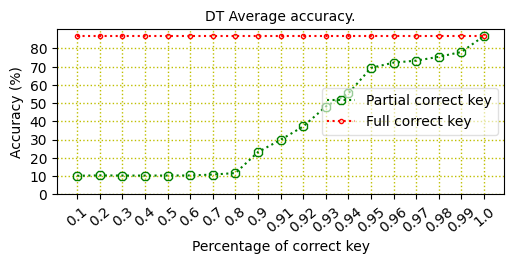

In [27]:
import matplotlib.pyplot as plt
c=['r','g','b','c','m', 'y', 'k']
m=['s','o','v','^','.']
fig, ax = plt.subplots(1,1,figsize=(5,2.5))
Average_acc = {}
for mix_percentage in Accuracy_history.keys():
    Average_acc[mix_percentage] = np.mean(Accuracy_history[mix_percentage])

print(Average_acc)

x, y = Average_acc.keys(), Average_acc.values()

ax.plot(np.arange(1,len(x)+1), [i*100 for i in y], linestyle=':', marker = '8' , color = c[1], fillstyle='none', label='Partial correct key')
ax.plot(np.arange(1,len(Accuracy_history)+1), [correct_KEY_accuracy * 100] * len(Accuracy_history), linestyle=':', marker = '.' , color = c[0], fillstyle='none', label='Full correct key')
ax.grid(color='y', linestyle=':', linewidth=1)
ax.set_title(f'DT Average accuracy.', fontsize=10)
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
ax.set_ylabel('Accuracy (%)') 
ax.set_xlabel('Percentage of correct key', fontsize=10)
ax.set_xticks(np.arange(1,len(x)+1,1))
ax.set_xticklabels(x, rotation=40)
ax.legend(loc='right', framealpha=0.6, fontsize = 10)
fig.tight_layout(pad=0.2)
plt.savefig('MNIST_Accuracy_Allmix_depth11.pdf')